In [ ]:
%load_ext autoreload
%autoreload 2

536
67
60
shape: (5, 12)
┌───────┬───────┬─────┬───────────┬───┬───────┬─────────────┬────────────┬─────────────┐
│ index ┆ files ┆ EPI ┆ SMP_start ┆ … ┆ EPI_2 ┆ SMP_start_2 ┆ SMP_stop_2 ┆ Class Label │
│ ---   ┆ ---   ┆ --- ┆ ---       ┆   ┆ ---   ┆ ---         ┆ ---        ┆ ---         │
│ u32   ┆ str   ┆ str ┆ i64       ┆   ┆ str   ┆ i64         ┆ i64        ┆ i64         │
╞═══════╪═══════╪═════╪═══════════╪═══╪═══════╪═════════════╪════════════╪═════════════╡
│ 0     ┆ a_2   ┆ VT  ┆ 256661    ┆ … ┆ CAS   ┆ 259810      ┆ 269811     ┆ 1           │
│ 1     ┆ a_2   ┆ PE  ┆ 457313    ┆ … ┆ CVT   ┆ 470692      ┆ 486294     ┆ 1           │
│ 2     ┆ a_2   ┆ PE  ┆ 826803    ┆ … ┆ CPR   ┆ 936775      ┆ 946608     ┆ 0           │
│ 3     ┆ a_2   ┆ PR  ┆ 1114462   ┆ … ┆ VT    ┆ 1141337     ┆ 1148379    ┆ 1           │
│ 4     ┆ a_2   ┆ PE  ┆ 1121525   ┆ … ┆ VF    ┆ 1148380     ┆ 1190708    ┆ 1           │
└───────┴───────┴─────┴───────────┴───┴───────┴─────────────┴────────────┴───────────

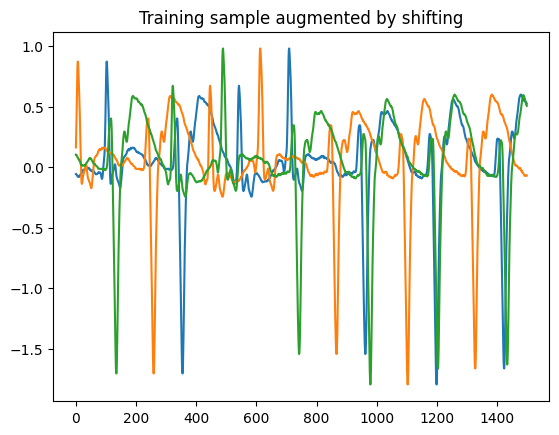

In [2]:
# Split training / validation data
import os
from pathlib import Path

import polars as pl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from cci.dataset import CropSample, RandomSample, ToTensor, TransitionDataset

clean_df = pl.read_csv("data/clean_df.csv").with_row_index()
(labels,) = clean_df.select("Class Label")
labels = labels.to_numpy()

train_idx, test_idx = train_test_split(
    range(len(clean_df)),
    stratify=labels,
    test_size=0.1,
)
train_idx, val_idx = train_test_split(
    train_idx,
    stratify=labels[train_idx],
    test_size=0.1,
)
train_df = clean_df.filter(pl.col("index").is_in(train_idx))
test_df = clean_df.filter(pl.col("index").is_in(test_idx))
val_df = clean_df.filter(pl.col("index").is_in(val_idx))
print(len(train_df))
print(len(test_df))
print(len(val_df))

print(train_df.head())
print(test_df.head())
print(val_df.head())

sample_length = 1500
root_dir = Path(os.environ["OOCHA_DIR"])

# Keep only some samples for testing
if True:
    train_df = train_df.drop("index").with_row_index().filter(pl.col("index") < 32)
    val_df = val_df.drop("index").with_row_index().filter(pl.col("index") < 32)
    test_df = test_df.drop("index").with_row_index().filter(pl.col("index") < 32)

ds_train = TransitionDataset(
    train_df,
    root_dir,
    transforms=[
        RandomSample(sample_length),
        ToTensor(),
    ],
)
ds_test = TransitionDataset(
    test_df,
    root_dir,
    transforms=[
        CropSample(sample_length),
        ToTensor(),
    ],
)
ds_val = TransitionDataset(
    val_df,
    root_dir,
    transforms=[
        CropSample(sample_length),
        ToTensor(),
    ],
)


for _ in range(3):
    sample = ds_train.__getitem__(2)
    signal, label = sample["signal"], sample["label"]
    plt.plot(signal)
plt.title("Training sample augmented by shifting")
plt.show()

In [ ]:
import torch
from torch import nn, optim, tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader

from cci.metrics import Metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    print(f"Running with device: {torch.cuda.get_device_name(device)}")
except AssertionError:
    pass

train_loader = DataLoader(
    ds_train,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
)
val_loader = DataLoader(
    ds_val,
    batch_size=32,
    pin_memory=True,
)
test_loader = DataLoader(
    ds_test,
    batch_size=32,
)

In [ ]:
import json
from typing import Any

from deepdiff import DeepHash
from rich.live import Live
from rich.progress import (
    Progress,
    TextColumn,
    TimeElapsedColumn,
)
from rich.table import Table

from cci.models.mlp import MLPModel

RESULTS = Path("results")
RESULTS.mkdir(exist_ok=True)

model_name = "MLP"
model = MLPModel()


run: dict[str, Any] = {
    "experiment": "MLP",
    "model_arch": str(model),
    "dataset": {
        "samples": 1500,
        "preprocessing": {},
        "set": "data/clean_df.csv",
        "test_set": {"augmentation": "random_shift"},
    },
    "hparams": {
        "learning_rate": 0.002,
        "batch_size": 32,
    },
}

model.to(device)
opt = optim.Adam(model.parameters())

# Unbalanced dataset => weighted loss fn
loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=tensor(ds_train.get_pos_weight()),
)
val_loss_fn = nn.BCEWithLogitsLoss()


run_hash = DeepHash(run)[run]
run["dir"] = RESULTS / run["experiment"] / run_hash
try:
    run["dir"].mkdir(parents=True)
except FileExistsError as e:
    print(e)  # TODO: Not ok
    if (run["dir"] / "results.json").exists():
        raise Exception("Experiment already finished.")
    print(f"WARN: Trying experiment {run['dir']} again")

In [ ]:
train_metrics = Metrics("train", len(ds_train), device)
val_metrics = Metrics("val", len(ds_val), device)
test_metrics = Metrics("test", len(ds_test), device)

table = Table(f"Training model: {model_name}")
metric_info = Progress(TextColumn("{task.description}"))
task_metrics = metric_info.add_task("Metrics")
progress = Progress(*Progress.get_default_columns(), TimeElapsedColumn())
task_epoch = progress.add_task("Epochs")
task_train = progress.add_task("Training")
task_validation = progress.add_task("Validation")
table.add_row(progress)
table.add_row(metric_info)

epochs = 1000
with Live(table):
    plot_cm = True

    for epoch in progress.track(
        range(1, epochs + 1), description="Epochs", task_id=task_epoch
    ):
        progress.reset(task_train)
        progress.reset(task_validation)
        train_metrics.reset()
        model.train()

        for data in progress.track(
            train_loader, description="Training", task_id=task_train
        ):
            sample, label = data["signal"].to(device), data["label"].to(device)
            opt.zero_grad()
            logits = model(sample)

            loss = loss_fn(logits, label.float())
            loss.backward()
            opt.step()

            predictions = F.sigmoid(logits)
            train_metrics.update(predictions, label, loss)
        # train_metrics.upload_metrics_epoch(run, epoch, plot_cm)
        train_metrics.save_metrics(epoch)

        # Track weights
        # track_params_dists(model, run)
        # track_gradients_dists(model, run)

        val_metrics.reset()
        model.eval()
        with torch.no_grad():
            for data in progress.track(
                val_loader, description="Validation", task_id=task_validation
            ):
                sample, label = data["signal"].to(device), data["label"].to(device)
                logits = model(sample)

                loss = val_loss_fn(logits, label.float())

                predictions = F.sigmoid(logits)
                val_metrics.update(predictions, label, loss)
        # val_metrics.upload_metrics_epoch(run, epoch, plot_cm)
        val_metrics.save_metrics(epoch)

        validation_values = val_metrics.compute()
        training_values = train_metrics.compute()
        metric_info.update(
            task_id=task_metrics,
            description=f"\nTraining\n Acc:{training_values['acc']:.3f}\n Loss{training_values['loss']:.3f}\n"
            f"Validation\n Acc:{validation_values['acc']:.3f}\n Loss:{validation_values['loss']:.3f}\n",
        )

        plot_cm = True if epoch % 10 == 0 else False

    # track_params_dists(model, run)
    # track_gradients_dists(model, run)
    # Run test set
    model.eval()
    with torch.no_grad():
        for data in progress.track(test_loader, description="Testing"):
            sample, label = data["signal"].to(device), data["label"].to(device)
            logits = model(sample)

            loss = val_loss_fn(logits, label.float())

            predictions = F.sigmoid(logits)
            test_metrics.update(predictions, label, loss)
    test_metrics.save_metrics(0)

    # train_metrics.upload_training_end(run)
    # val_metrics.upload_training_end(run)
    # test_metrics.upload_test(run)

In [ ]:
train_metrics.write_metrics(run["dir"])
val_metrics.write_metrics(run["dir"])
test_metrics.write_metrics(run["dir"])

# End experiment
run["results"] = {
    "best_train": train_metrics.best_metrics(),
    "best_val": val_metrics.best_metrics(),
}
with open(run["dir"] / "results.json", "w") as f:
    json.dump(run, f)